# What does the distribution of CLS tokens look like?

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns

import numpy as np
import pandas as pd

from tqdm import tqdm
import torch
from ipywidgets import interact, IntSlider

In [2]:
from src.model.setup import image_model_setup
from src.model.CLS_token_probing import ModuleSpecificDecoder
from src.data.activity_dataset import OnlineLayerInputDataset
model_name = "facebook/dinov2-base"
dataset_name = "temp_dataset_subsample"

model, image_datasets, _ = image_model_setup(model_name, dataset_name, 1000)
_=model.model.eval()
model_analysis, _, _ = image_model_setup(model_name, dataset_name, 1000)
model_analysis.to('mps')
_=model_analysis.model.eval()

W0217 18:20:29.542000 11357 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## What does the distribution of logit predictions look like?

In [3]:
layer_ind = 10
layer_name = f'dinov2.encoder.layer.{layer_ind}'
probe =  ModuleSpecificDecoder.from_pretrained(f'learned_probes/probes_replace/layer{layer_ind}_probe_replace/', 
                                                mode='replace'
                                              )
probe = probe.eval()
probe = probe.to('mps')

Loading weights from local directory


In [4]:
ds = OnlineLayerInputDataset(model, layer_name, image_datasets['validation'], device='mps')
base_module = model_analysis.module_dict[layer_name]

In [5]:
batch = next(iter(ds))

In [6]:
samples = []

for i in range(50):
    samples.append(probe.forward(batch['dinov2.encoder.layer.10'], base_module).detach().cpu())

samples = torch.stack(samples)

In [7]:
def plot_logits(id_idx):
    plt.figure(figsize=(5, 5))
    df = pd.DataFrame(samples[:,id_idx,:]).melt(var_name='label', value_name='logit')
    sns.lineplot(data=df, x='label', y='logit', errorbar=('pi', 100))
    plt.show()

interact(plot_logits, id_idx=IntSlider(min=0, max=samples.shape[1]-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='id_idx', max=63), Output()), _dom_classes=('widget-inter…

First impression: there is hardly and variation in the individual samples. It is dwarfed by variation between points.

In rare cases (e.g. index 14) this might make a difference.

In [8]:
figsize(10,10)
def plot_mean_var(id_idx):
    plt.figure(figsize=(10,10))
    plt.subplots(3,1, sharex=True)
    plt.subplot(3,1,1)
    plt.plot(torch.var( samples[:,id_idx,:], dim=0))
    plt.title('variance')
    plt.subplot(3,1,2)
    plt.plot(torch.var(samples[:,id_idx,:], dim=0) / torch.mean(samples[:,id_idx,:], dim=0))
    plt.title('var/mean')
    plt.subplot(3,1,3)
    plt.plot(1./ torch.mean(samples[:,id_idx,:], dim=0))
    plt.title('1 / mean')
    plt.show()

interact(plot_mean_var, id_idx=IntSlider(min=0, max=samples.shape[1]-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='id_idx', max=63), Output()), _dom_classes=('widget-inter…

Occasional spikes of variance that to the same scale as the mean, but this is almost always where the mean is close to 0.

In [9]:
figsize(10,10)
def plot_mean_var(id_idx):
    probs = torch.nn.functional.softmax(samples, dim=2)
    plt.figure(figsize=(10,10))
    plt.subplots(3,1, sharex=True)
    plt.subplot(3,1,1)
    plt.plot(torch.var( probs[:,id_idx,:], dim=0))
    plt.title('variance')
    plt.subplot(3,1,2)
    plt.plot(torch.var(probs[:,id_idx,:], dim=0) / torch.mean(probs[:,id_idx,:], dim=0))
    plt.title('var/mean')
    plt.subplot(3,1,3)
    plt.plot(torch.mean(probs[:,id_idx,:], dim=0))
    plt.title('mean')
    plt.show()

interact(plot_mean_var, id_idx=IntSlider(min=0, max=samples.shape[1]-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='id_idx', max=63), Output()), _dom_classes=('widget-inter…

In softmax, the variance does align with the mean. I suspect that this is because the non-linear expansion of large mean values.

In [10]:
decoded = samples.argmax(2)
num_outs = []
for i in range(64):
    num_outs.append(len(torch.unique(decoded[:,i])))


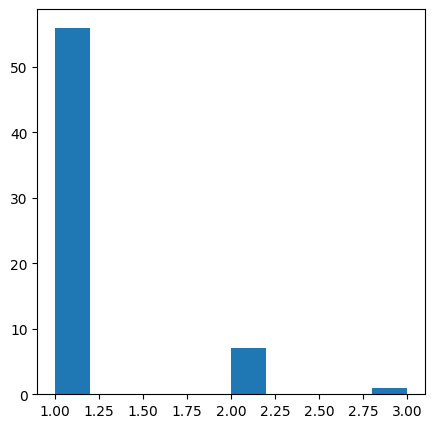

In [11]:
figsize(5,5)
_=plt.hist(num_outs)

There are _some_ places where the read-outs give multiple answers.

### Self-calibration

How well do the logit read-outs predict the multiple answers that they give?

In [12]:
probs = torch.nn.functional.softmax(samples, dim=2)

In [13]:
probs.shape

torch.Size([50, 64, 1000])

In [14]:
mean_prob = probs.mean(0)

In [15]:
choices = probs.argmax(dim=2)

In [16]:
mean_prob.shape

torch.Size([64, 1000])

In [17]:
# for every datapoint that we choose, ask about the frequency of that choice vs the mean probability assigned to that point

pairs = []

num_samples = 50

for sample_ind in range(64):
    curr_choices, curr_counts = choices[:,sample_ind].unique(return_counts=True)

    for i, choice in enumerate(curr_choices):
        prob = mean_prob[sample_ind, choice]
        frequency = curr_counts[i] / num_samples
        pairs.append((prob.item(), frequency.item()))



In [18]:
sample_ind = 0 

In [19]:
probs, freqs = list(zip(*pairs))

Text(0, 0.5, 'frequency')

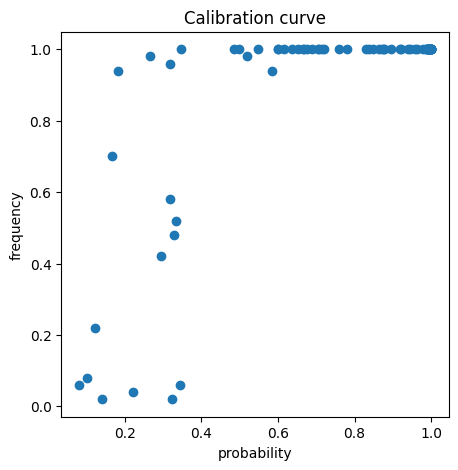

In [20]:
figsize(5,5)
plt.scatter(probs, freqs)
plt.title('Calibration curve')
plt.xlabel('probability')
plt.ylabel('frequency')

Postive: the relationship is calbration-like in that it is vaguely monotonic.

Negative: the relationship is far from linear.

Now lets apply this analysis to the whole validation set.

In [21]:
def probability_vs_frequency(samples):
    num_samples = samples.shape[0]
    num_inputs = samples.shape[1]

    probs = torch.nn.functional.softmax(samples, dim=2)
    mean_prob = probs.mean(0)
    choices = probs.argmax(dim=2)
    
    pairs = []
    
    for sample_ind in range(64):
        curr_choices, curr_counts = choices[:,sample_ind].unique(return_counts=True)
    
        for i, choice in enumerate(curr_choices):
            prob = mean_prob[sample_ind, choice]
            frequency = curr_counts[i] / num_samples
            pairs.append((prob.item(), frequency.item()))

    return pairs

In [22]:
pairs = probability_vs_frequency(samples)

In [23]:
probs, freqs = list(zip(*pairs))

In [24]:
from rich.progress import track

In [26]:
pairs = []
for batch in track(ds, total=50000/64):
    # sample model read-outs
    samples = []

    for i in range(100):
        samples.append(probe.forward(batch['dinov2.encoder.layer.10'], base_module).detach().cpu())
    
    samples = torch.stack(samples)

    pairs.extend(probability_vs_frequency(samples))

Output()

IndexError: index 16 is out of bounds for dimension 1 with size 16

In [30]:
probs, freqs = list(zip(*pairs))

Text(0, 0.5, 'frequency')

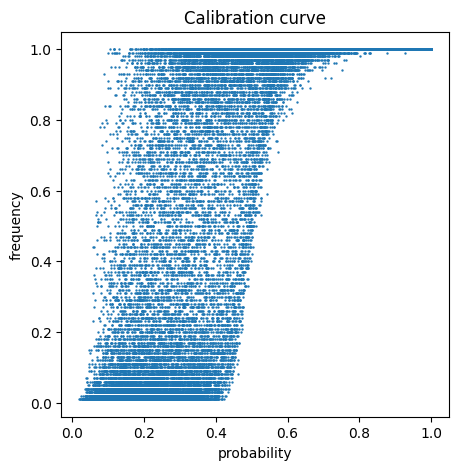

In [37]:
plt.scatter(probs, freqs, s=0.5)
plt.title('Calibration curve')
plt.xlabel('probability')
plt.ylabel('frequency')

Not much more to say, but it does illuminate the boundaries of the calibration failures.